<a href="https://colab.research.google.com/github/BYK82/AIFFEL/blob/main/%5BE_17%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17-6. 프로젝트 - Movielens 영화 SBR
이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

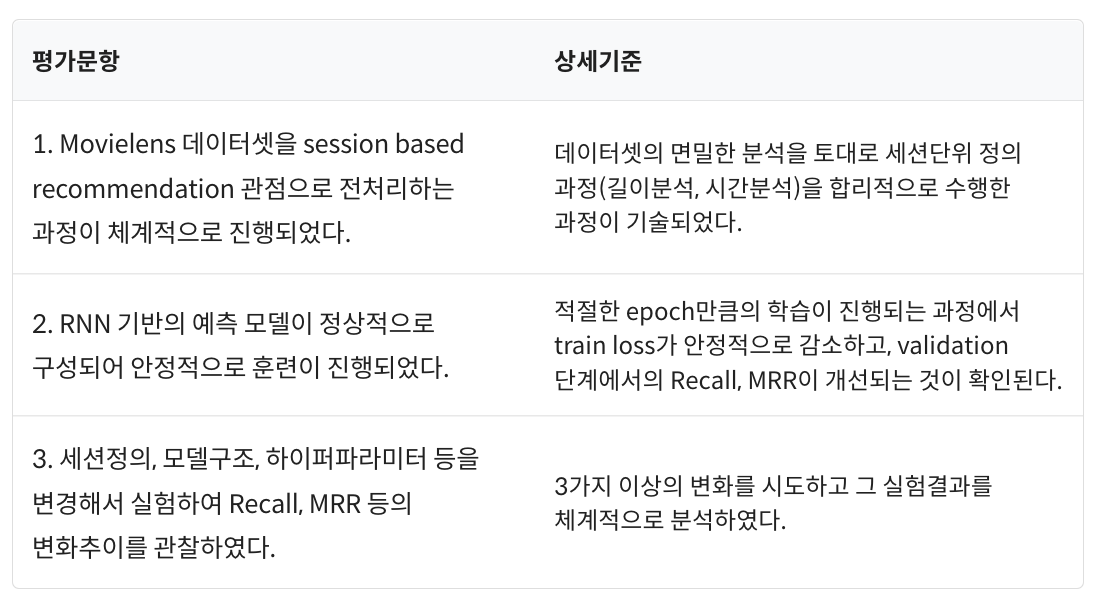

In [ ]:
import os   #디렉토리 관리
import matplotlib.pyplot as plt   #데이터 시각화

import time   #timestamp => time
from datetime import datetime   #timestamp => time
from datetime import timedelta   #시간 연산


import numpy as np   #행렬 연산
import pandas as pd   #데이터프레임 관리
pd.options.display.float_format = '{:.3f}'.format   #소숫점 세자리 출력


#모델 설게==========================
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
#End================================


import warnings   #경고
warnings.filterwarnings('ignore')   #경고 무시

In [ ]:
data_path = Path('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 17') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [ ]:
data['UserId'].nunique(), data['ItemId'].nunique()


(6040, 3706)

## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.



In [ ]:
# 데이터 분석 
analy_data = data.copy()
analy_data.head(5)

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [ ]:
analy_data["Time_h"] = analy_data["Time"].apply(lambda x: datetime.fromtimestamp(x))

analy_data.sort_values("Time_h")

,UserId,ItemId,Rating,Time,Time_h
1000138,6040,858,4,956703932,2000-04-25 23:05:32
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
825793,4958,2399,1,1046454338,2003-02-28 17:45:38
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825724,4958,3264,4,1046454548,2003-02-28 17:49:08
825731,4958,2634,3,1046454548,2003-02-28 17:49:08


**************************************************
count       6040.000
mean     2158428.273
std      5466795.946
min           39.724
25%          349.795
50%         1107.985
75%       475082.376
max     43070685.021
Name: Time, dtype: float64
**************************************************


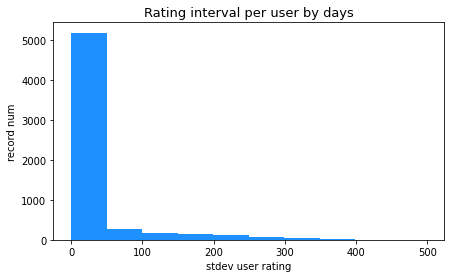

In [ ]:
#유저별 평가 간격
test = analy_data.groupby("UserId")["Time"].std().reset_index()

print("*" * 50)
print(test["Time"].describe())
print("*" * 50)

plt.figure(figsize=(7, 4))
plt.title("Rating interval per user by days", size= 13)
plt.hist(test["Time"]/60/60/24, bins=10, color="#1e90ff")
plt.ylabel("record num")
plt.xlabel("stdev user rating")
plt.show()

### 1.1 1분 단위 세션 정의

In [ ]:
session_1min = data.copy()

def cut_1min(x):
    date_ = datetime.fromtimestamp(x)
    date_ = date_ - timedelta(seconds=date_.second)
    return int(time.mktime(date_.timetuple()))

session_1min["Time_1min"] = session_1min["Time"].apply(cut_1min)   #초단위 제외


session_1min.head(5)

,UserId,ItemId,Rating,Time,Time_1min
31,1,3186,4,978300019,978300000
22,1,1270,5,978300055,978300000
27,1,1721,4,978300055,978300000
37,1,1022,5,978300055,978300000
24,1,2340,3,978300103,978300060


In [ ]:
# UserId 및 Time 중복 레콛드 통합

session_1min = session_1min.groupby(["UserId", "Time"])["Time_1min"].mean().reset_index()
session_1min

,UserId,Time,Time_1min
0,1,978300019,978300000.000
1,1,978300055,978300000.000
2,1,978300103,978300060.000
3,1,978300172,978300120.000
4,1,978300275,978300240.000
...,...,...,...
471158,6040,997454398,997454340.000
471159,6040,997454429,997454400.000
471160,6040,997454464,997454460.000
471161,6040,997454486,997454460.000


In [ ]:
# UserId 와 Time_1min 문자열 합치기

comb_user_time = session_1min.loc[:, ["UserId", "Time_1min"]].copy()
comb_user_time = comb_user_time.astype({"UserId": str, "Time_1min": str})   #문자열로 변환

comb_user_time = comb_user_time["UserId"] + comb_user_time["Time_1min"]
comb_user_time = comb_user_time.astype(float)
comb_user_time = comb_user_time.astype(int)

session_1min["comb_user_time"] = comb_user_time
session_1min

,UserId,Time,Time_1min,comb_user_time
0,1,978300019,978300000.000,1978300000
1,1,978300055,978300000.000,1978300000
2,1,978300103,978300060.000,1978300060
3,1,978300172,978300120.000,1978300120
4,1,978300275,978300240.000,1978300240
...,...,...,...,...
471158,6040,997454398,997454340.000,6040997454340
471159,6040,997454429,997454400.000,6040997454400
471160,6040,997454464,997454460.000,6040997454460
471161,6040,997454486,997454460.000,6040997454460


In [ ]:
# unique 인덱스로 변환하기
session_list = session_1min["comb_user_time"]
unique_list = session_1min["comb_user_time"].unique()
unique_list = [np.where(unique_list == session)[0][0] for session in session_list]

session_1min["Session"] = unique_list

session_1min

,UserId,Time,Time_1min,comb_user_time,Session
0,1,978300019,978300000.000,1978300000,0
1,1,978300055,978300000.000,1978300000,0
2,1,978300103,978300060.000,1978300060,1
3,1,978300172,978300120.000,1978300120,2
4,1,978300275,978300240.000,1978300240,3
...,...,...,...,...,...
471158,6040,997454398,997454340.000,6040997454340,284968
471159,6040,997454429,997454400.000,6040997454400,284969
471160,6040,997454464,997454460.000,6040997454460,284970
471161,6040,997454486,997454460.000,6040997454460,284970


In [ ]:
# 기존 데이터와 Session 결합

session_1min.drop(columns=["Time_1min", "comb_user_time"], inplace=True)
session_1min_data = pd.merge(data, session_1min, on=["UserId", "Time"])

session_1min_data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,1
...,...,...,...,...,...
1000204,6040,2917,4,997454429,284969
1000205,6040,1921,4,997454464,284970
1000206,6040,1784,3,997454464,284970
1000207,6040,161,3,997454486,284970


In [ ]:
# 과정 통합 함수 생성

def get_session_dataset(session_min_df, session_column):
    #UserId와 Time에 대한 중복 레코드를 통합=======================
    session_min_df = session_min_df.groupby(["UserId", "Time"])[session_column].mean().reset_index()
    #End===========================================================


    #UserId 와 Time_1min 문자열 합치기=============================
    comb_user_time = session_min_df.loc[:, ["UserId", session_column]].copy()
    comb_user_time = comb_user_time.astype({"UserId": str, session_column: str})   #문자열로 변환

    comb_user_time = comb_user_time["UserId"] + comb_user_time[session_column]
    comb_user_time = comb_user_time.astype(float)
    comb_user_time = comb_user_time.astype(int)

    session_min_df["comb_user_time"] = comb_user_time
    #End===========================================================


    #unique 인덱스로 변환하기======================================
    session_list = session_min_df["comb_user_time"]
    unique_list = session_min_df["comb_user_time"].unique()
    unique_list = [np.where(unique_list == session)[0][0] for session in session_list]

    session_min_df["Session"] = unique_list
    #End===========================================================


    #기존 데이터와 Session 결합
    session_min_df.drop(columns=[session_column, "comb_user_time"], inplace=True)
    session_min_df_data = pd.merge(data, session_min_df, on=["UserId", "Time"])
    #End===========================================================

    return session_min_df_data

***********************************
count   29366.000
mean        1.893
std         1.489
min         1.000
25%         1.000
50%         1.000
75%         2.000
max        11.000
dtype: float64
***********************************
98% session length 7.0


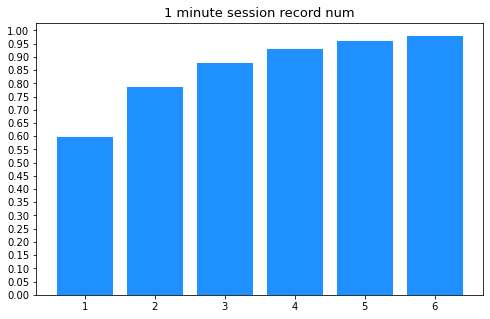

In [ ]:
## 세션 길이 중심 분석
session_length = session_1min_data.groupby("Session").size()

print("*" * 35)
print(session_length.describe())
print("*" * 35)
print("98% session length", session_length.quantile(0.98))

#세션 길이에 따른 분포
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_98 = length_percent_cumsum[length_percent_cumsum < 0.98]


#시각화
plt.figure(figsize=(8, 5))
plt.title('1 minute session record num', size=13)
plt.bar(x=length_percent_cumsum_98.index,
        height=length_percent_cumsum_98, color="#1e90ff")
plt.xticks(length_percent_cumsum_98.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

In [ ]:
# 세션 시간 중심 분석
oldest, latest = session_1min_data['Time'].min(), session_1min_data['Time'].max()

month1 = len(session_1min_data[session_1min_data["Time"] > (latest - 30 * 1 * 86400)])
month6 = len(session_1min_data[session_1min_data["Time"] > (latest - 30 * 6 * 86400)])
month12 = len(session_1min_data[session_1min_data["Time"] > (latest - 365 * 1 * 86400)])
month24 = len(session_1min_data[session_1min_data["Time"] > (latest - 365 * 2 * 86400)])


print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 35)
print("1 month ago data num:", month1)
print("6 month ago data num:", month6)
print("12 month ago data num:", month12)
print("24 month ago data num:", month24)
print("*" * 35)

data date: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50
***********************************
1 month ago data num: 1551
6 month ago data num: 8823
12 month ago data num: 21704
24 month ago data num: 69349
***********************************


### 1.2 30분 단위 세션 정의

In [ ]:
session_30min = data.copy()

def cut_30min(x):
    date_ = datetime.fromtimestamp(x)
    date_ = date_ - timedelta(seconds=date_.second)
        
    if int(date_.minute) < 30:
        date_ = date_ - timedelta(minutes=date_.minute)
    else:
        date_ = date_ + timedelta(minutes=30 - date_.minute)
    return int(time.mktime(date_.timetuple()))


session_30min["Time_30min"] = session_30min["Time"].apply(cut_30min)   #초단위 제외


session_30min[25:30]

,UserId,ItemId,Rating,Time,Time_30min
2,1,914,3,978301968,978301800
6,1,1287,5,978302039,978301800
19,1,2797,4,978302039,978301800
38,1,2762,4,978302091,978301800
52,1,1246,4,978302091,978301800


In [ ]:
# 30분 단위 세션 데이터 획득

session_30min_data = get_session_dataset(session_30min, "Time_30min")

session_30min_data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,0
...,...,...,...,...,...
1000204,6040,2917,4,997454429,39219
1000205,6040,1921,4,997454464,39219
1000206,6040,1784,3,997454464,39219
1000207,6040,161,3,997454486,39219


***********************************
count   10070.000
mean        5.535
std        11.145
min         1.000
25%         1.000
50%         2.000
75%         4.000
max       124.000
dtype: float64
***********************************
98% session length 44.0


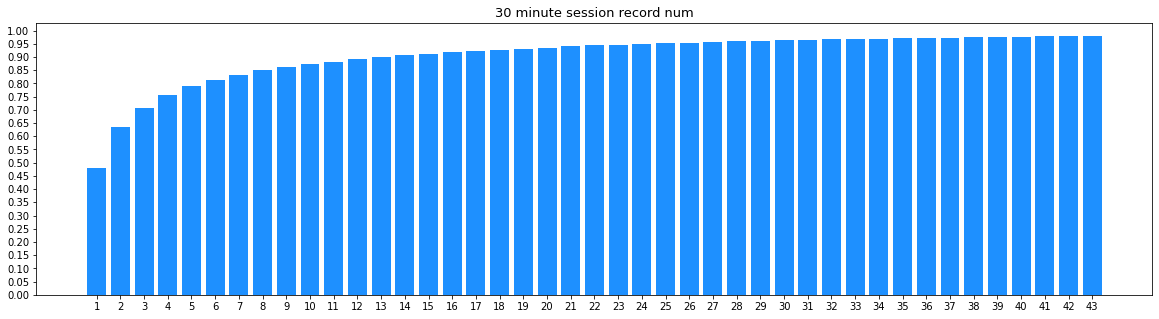

In [ ]:
# 세션 길이 중심 분석

session_length = session_30min_data.groupby("Session").size()

print("*" * 35)
print(session_length.describe())
print("*" * 35)
print("98% session length", session_length.quantile(0.98))

#세션 길이에 따른 분포
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_98 = length_percent_cumsum[length_percent_cumsum < 0.98]


#시각화
plt.figure(figsize=(20, 5))
plt.title('30 minute session record num', size=13)
plt.bar(x=length_percent_cumsum_98.index,
        height=length_percent_cumsum_98, color="#1e90ff")
plt.xticks(length_percent_cumsum_98.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

In [ ]:
# 세션 시간 중심 분석

oldest, latest = session_30min_data['Time'].min(), session_30min_data['Time'].max()

month1 = len(session_30min_data[session_30min_data["Time"] > (latest - 30 * 1 * 86400)])
month6 = len(session_30min_data[session_30min_data["Time"] > (latest - 30 * 6 * 86400)])
month12 = len(session_30min_data[session_30min_data["Time"] > (latest - 365 * 1 * 86400)])
month24 = len(session_30min_data[session_30min_data["Time"] > (latest - 365 * 2 * 86400)])


print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 35)
print("1 month ago data num:", month1)
print("6 month ago data num:", month6)
print("12 month ago data num:", month12)
print("24 month ago data num:", month24)
print("*" * 35)

data date: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50
***********************************
1 month ago data num: 1551
6 month ago data num: 8823
12 month ago data num: 21704
24 month ago data num: 69349
***********************************


### 1.3 1시간 단위 세션 정의

In [ ]:
session_60min = data.copy()

def cut_60min(x):
    date_ = datetime.fromtimestamp(x)
    date_ = date_ - timedelta(seconds=date_.second, minutes=date_.minute)
    return int(time.mktime(date_.timetuple()))


session_60min["Time_60min"] = session_60min["Time"].apply(cut_60min)   #초단위 제외


session_60min.head(5)

,UserId,ItemId,Rating,Time,Time_60min
31,1,3186,4,978300019,978300000
22,1,1270,5,978300055,978300000
27,1,1721,4,978300055,978300000
37,1,1022,5,978300055,978300000
24,1,2340,3,978300103,978300000


In [ ]:
session_60min_data = get_session_dataset(session_60min, "Time_60min")

session_60min_data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,0
...,...,...,...,...,...
1000204,6040,2917,4,997454429,31967
1000205,6040,1921,4,997454464,31967
1000206,6040,1784,3,997454464,31967
1000207,6040,161,3,997454486,31967


***********************************
count   9107.000
mean       6.049
std       13.475
min        1.000
25%        1.000
50%        2.000
75%        4.000
max      178.000
dtype: float64
***********************************
98% session length 53.0


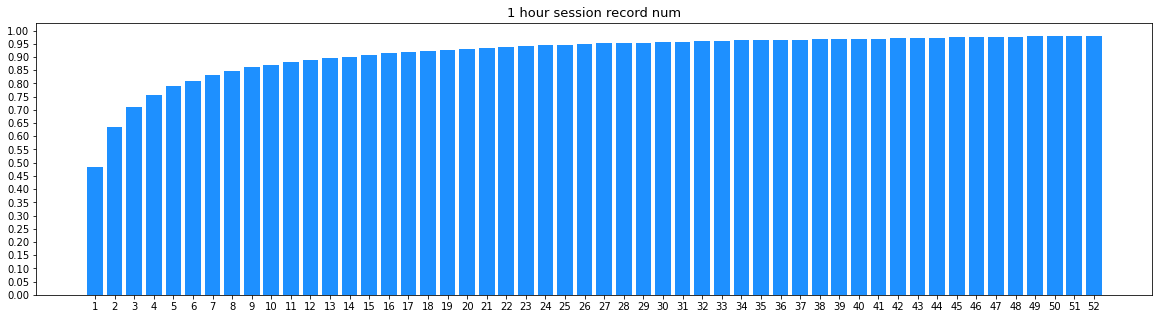

In [ ]:
# 세션 길이 중심 분석

session_length = session_60min_data.groupby("Session").size()

print("*" * 35)
print(session_length.describe())
print("*" * 35)
print("98% session length", session_length.quantile(0.98))

#세션 길이에 따른 분포
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_98 = length_percent_cumsum[length_percent_cumsum < 0.98]


#시각화
plt.figure(figsize=(20, 5))
plt.title('1 hour session record num', size=13)
plt.bar(x=length_percent_cumsum_98.index,
        height=length_percent_cumsum_98, color="#1e90ff")
plt.xticks(length_percent_cumsum_98.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

In [ ]:
# 세션 시간 중심 분석

oldest, latest = session_60min_data['Time'].min(), session_60min_data['Time'].max()

month1 = len(session_60min_data[session_60min_data["Time"] > (latest - 30 * 1 * 86400)])
month6 = len(session_60min_data[session_60min_data["Time"] > (latest - 30 * 6 * 86400)])
month12 = len(session_60min_data[session_60min_data["Time"] > (latest - 365 * 1 * 86400)])
month24 = len(session_60min_data[session_60min_data["Time"] > (latest - 365 * 2 * 86400)])


print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 35)
print("1 month ago data num:", month1)
print("6 month ago data num:", month6)
print("12 month ago data num:", month12)
print("24 month ago data num:", month24)
print("*" * 35)

data date: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50
***********************************
1 month ago data num: 1551
6 month ago data num: 8823
12 month ago data num: 21704
24 month ago data num: 69349
***********************************


### 1.4 데이터 전처리

In [ ]:
# 세션 길이 중심 전처리

def cut_record(df, record_num):
    df = df.copy()
    size = df.groupby("Session").size().reset_index()
    df = pd.merge(df, size, on=["Session"])
    df = df[df[0] <= record_num]
    df.drop(columns=[0], inplace=True)
    return df


session_1min_data = cut_record(session_1min_data, 11)
session_30min_data = cut_record(session_30min_data, 141)
session_60min_data = cut_record(session_60min_data, 198)

In [ ]:
# 세션 시간 중심 전처리

def cut_time(df, base_date):
    df = df.copy()
    base_date = df["Time"].max() - base_date
    df = df[df["Time"] >= base_date]
    return df


session_1min_data = cut_time(session_1min_data, 365 * 2 * 86400)
session_30min_data = cut_time(session_30min_data, 365 * 2 * 86400)
session_60min_data = cut_time(session_60min_data, 365 * 2 * 86400)

oldest, latest = session_1min_data['Time'].min(), session_1min_data['Time'].max()


print("*" * 50)
print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 50)

**************************************************
data date: 2001-02-28 19:06:53 ~ 2003-02-28 17:49:50
**************************************************


In [ ]:
# 평점 중심 전처리

session_1min_data = session_1min_data[session_1min_data['Rating'] >= 3]
session_30min_data = session_30min_data[session_30min_data['Rating'] >= 3]
session_60min_data = session_60min_data[session_60min_data['Rating'] >= 3]

In [ ]:
# 데이터 분할

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Session')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (n_days * 86400)].index
    session_in_test = session_last_time[session_last_time >= final_time - (n_days * 86400)].index

    before_date = data[data['Session'].isin(session_in_train)]
    after_date = data[data['Session'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date


def get_integrated_data(df, split_rate):
    train, test = split_by_date(df, split_rate)
    train, validation = split_by_date(train, int(split_rate * 0.2))
    return (train, validation, test)



train_1min, val_1min, test_1min = get_integrated_data(session_1min_data, 146)
train_30min, val_30min, test_30min = get_integrated_data(session_30min_data, 146)
train_60min, val_60min, test_60min = get_integrated_data(session_60min_data, 146)


print("*" * 50)
print("train data shape:", train_1min.shape)
print("validation data shape:", val_1min.shape)
print("test data shape:", test_1min.shape)
print("*" * 50)

**************************************************
train data shape: (48592, 5)
validation data shape: (914, 5)
test data shape: (6037, 5)
**************************************************


In [ ]:
# 학습 데이터를 기준으로 인덱싱

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df


def get_indexing_data(train, val, test):
    id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}
    train, val, test = indexing(train, id2idx), indexing(val, id2idx), indexing(test, id2idx)
    return (train, val, test)


train_1min, val_1min, test_1min = get_indexing_data(train_1min, val_1min, test_1min)
train_30min, val_30min, test_30min = get_indexing_data(train_30min, val_30min, test_30min)
train_60min, val_60min, test_60min = get_indexing_data(train_60min, val_60min, test_60min)

## Step 2. 미니 배치의 구성

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['Session'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['Session'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('Session').size().cumsum()
        return offsets

In [ ]:
# Session-Parallel 미니배치 생성 클래스

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

### Step 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.



In [ ]:
# 평가지표 설계
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [ ]:
# 하이퍼파라미터

class Args:
    def __init__(self, tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20):
        self.tr, self.val, self.test = tr, val, test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['Session'].nunique()
        self.batch_size, self.drop_rate, self.lr = batch_size, drop_rate, lr
        self.hsz = hsz
        self.epochs = epochs
        self.k = k

args_1min = Args(train_1min, val_1min, test_1min)
args_30min = Args(train_30min, val_30min, test_30min)
args_60min = Args(train_60min, val_60min, test_60min)

In [ ]:
# 모델 생성 함수

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    return model

sample_model = create_model(args_1min)
sample_model.summary()
sample_model = None

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(64, 1, 3149)]           0         
                                                                 
 GRU (GRU)                   [(64, 50),                480150    
                              (64, 50)]                          
                                                                 
 dropout_7 (Dropout)         (64, 50)                  0         
                                                                 
 dense_7 (Dense)             (64, 3149)                160599    
                                                                 
Total params: 640,749
Trainable params: 640,749
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.



In [ ]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    
    dic = {"val_recall": [], "val_mrr": []}

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['Session'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        dic["val_recall"].append(val_recall)
        dic["val_mrr"].append(val_mrr)
        
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
    return dic


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['Session'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 4.1 1분 기준 세션 모델 학습

In [ ]:
model_1min = create_model(args_1min)
history = train_model(model_1min, args_1min)

Evaluation:  80%|████████  | 4/5 [00:03<00:00,  1.03it/s]


	 - Recall@20 epoch 1: 0.054688
	 - MRR@20    epoch 1: 0.011825



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.83it/s]


	 - Recall@20 epoch 2: 0.046875
	 - MRR@20    epoch 2: 0.011693



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.80it/s]


	 - Recall@20 epoch 3: 0.058594
	 - MRR@20    epoch 3: 0.009858



Evaluation:  80%|████████  | 4/5 [00:03<00:00,  1.04it/s]


	 - Recall@20 epoch 4: 0.054688
	 - MRR@20    epoch 4: 0.009957



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.82it/s]


	 - Recall@20 epoch 5: 0.054688
	 - MRR@20    epoch 5: 0.008641



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.41it/s]


	 - Recall@20 epoch 6: 0.039062
	 - MRR@20    epoch 6: 0.009651



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.72it/s]


	 - Recall@20 epoch 7: 0.054688
	 - MRR@20    epoch 7: 0.009207



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.80it/s]


	 - Recall@20 epoch 8: 0.062500
	 - MRR@20    epoch 8: 0.010106



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.63it/s]


	 - Recall@20 epoch 9: 0.062500
	 - MRR@20    epoch 9: 0.012942



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.80it/s]

	 - Recall@20 epoch 10: 0.050781
	 - MRR@20    epoch 10: 0.015185



### 4.2 30분 기준 세션 모델 학습

In [ ]:
model_30min = create_model(args_30min)
history = train_model(model_30min, args_30min)

Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]


	 - Recall@20 epoch 1: 0.015625
	 - MRR@20    epoch 1: 0.002441



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 2: 0.015625
	 - MRR@20    epoch 2: 0.002511



Evaluation:  18%|█▊        | 2/11 [00:02<00:10,  1.11s/it]


	 - Recall@20 epoch 3: 0.015625
	 - MRR@20    epoch 3: 0.002511



Evaluation:  18%|█▊        | 2/11 [00:01<00:08,  1.04it/s]


	 - Recall@20 epoch 4: 0.023438
	 - MRR@20    epoch 4: 0.002648



Evaluation:  18%|█▊        | 2/11 [00:01<00:07,  1.16it/s]


	 - Recall@20 epoch 5: 0.015625
	 - MRR@20    epoch 5: 0.001576



Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]


	 - Recall@20 epoch 6: 0.015625
	 - MRR@20    epoch 6: 0.003064



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 7: 0.007812
	 - MRR@20    epoch 7: 0.000460



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 8: 0.007812
	 - MRR@20    epoch 8: 0.001563



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 9: 0.031250
	 - MRR@20    epoch 9: 0.005679



Evaluation:  18%|█▊        | 2/11 [00:04<00:18,  2.02s/it]

	 - Recall@20 epoch 10: 0.046875
	 - MRR@20    epoch 10: 0.007609



### 4.3 1시간 기준 세션 모델 학습

In [ ]:
model_60min = create_model(args_60min)
history = train_model(model_60min, args_60min)

Evaluation:   9%|▉         | 1/11 [00:01<00:14,  1.47s/it]


	 - Recall@20 epoch 1: 0.015625
	 - MRR@20    epoch 1: 0.003906



Evaluation:   9%|▉         | 1/11 [00:00<00:06,  1.56it/s]


	 - Recall@20 epoch 2: 0.015625
	 - MRR@20    epoch 2: 0.003906



Evaluation:   9%|▉         | 1/11 [00:01<00:11,  1.11s/it]


	 - Recall@20 epoch 3: 0.015625
	 - MRR@20    epoch 3: 0.003906



Evaluation:   9%|▉         | 1/11 [00:01<00:11,  1.10s/it]


	 - Recall@20 epoch 4: 0.031250
	 - MRR@20    epoch 4: 0.004948



Evaluation:   9%|▉         | 1/11 [00:00<00:06,  1.56it/s]


	 - Recall@20 epoch 5: 0.015625
	 - MRR@20    epoch 5: 0.003125



Evaluation:   9%|▉         | 1/11 [00:00<00:05,  1.78it/s]


	 - Recall@20 epoch 6: 0.031250
	 - MRR@20    epoch 6: 0.003806



Evaluation:   9%|▉         | 1/11 [00:00<00:05,  1.70it/s]


	 - Recall@20 epoch 7: 0.031250
	 - MRR@20    epoch 7: 0.007812



Evaluation:   9%|▉         | 1/11 [00:00<00:05,  1.80it/s]


	 - Recall@20 epoch 8: 0.031250
	 - MRR@20    epoch 8: 0.006410



Evaluation:   9%|▉         | 1/11 [00:00<00:05,  1.77it/s]


	 - Recall@20 epoch 9: 0.015625
	 - MRR@20    epoch 9: 0.007812



Evaluation:   9%|▉         | 1/11 [00:00<00:05,  1.79it/s]

	 - Recall@20 epoch 10: 0.015625
	 - MRR@20    epoch 10: 0.000868



### Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 5.1 1분 기준 세션 모델 학습

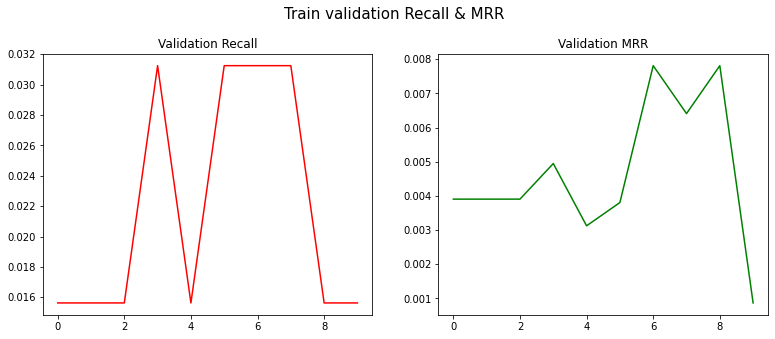

In [ ]:
plt.figure(figsize=(13, 5))
plt.suptitle("Train validation Recall & MRR", fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.title("Validation Recall")
plt.plot(history["val_recall"], color="red")

plt.subplot(1, 2, 2)
plt.title("Validation MRR")
plt.plot(history["val_mrr"], color="green")
plt.show()

In [ ]:
test_model(model_1min, args_1min, test_1min)

Evaluation:  98%|█████████▊| 41/42 [00:31<00:00,  1.30it/s]

	 - Recall@20: 0.072790
	 - MRR@20: 0.021903



### 5.2 30분 기준 세션 모델 학습

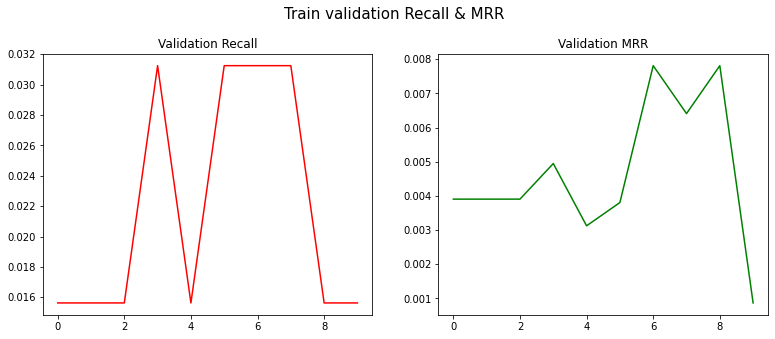

In [ ]:
plt.figure(figsize=(13, 5))
plt.suptitle("Train validation Recall & MRR", fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.title("Validation Recall")
plt.plot(history["val_recall"], color="red")

plt.subplot(1, 2, 2)
plt.title("Validation MRR")
plt.plot(history["val_mrr"], color="green")
plt.show()

In [ ]:
test_model(model_30min, args_30min, test_30min)

Evaluation:  79%|███████▊  | 59/75 [00:31<00:08,  1.87it/s]

	 - Recall@20: 0.100900
	 - MRR@20: 0.026711



### 5.3 1시간 기준 세션 모델 학습

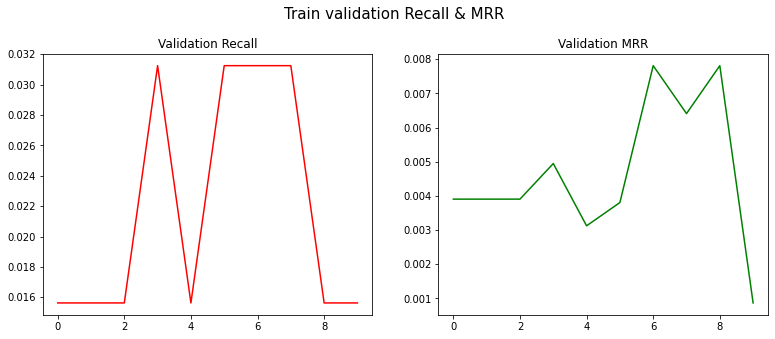

In [ ]:
plt.figure(figsize=(13, 5))
plt.suptitle("Train validation Recall & MRR", fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.title("Validation Recall")
plt.plot(history["val_recall"], color="red")

plt.subplot(1, 2, 2)
plt.title("Validation MRR")
plt.plot(history["val_mrr"], color="green")
plt.show()

In [ ]:
test_model(model_60min, args_60min, test_60min)

Evaluation:  75%|███████▍  | 56/75 [00:29<00:10,  1.89it/s]

	 - Recall@20: 0.097098
	 - MRR@20: 0.029147



## 하이퍼 파라미터 변경 후 모델 테스트

- 개선1 (lr 영향)
  - lr=0.1
  - drop_rate=0.1
  - batch_size=64

In [ ]:
args_30min = Args(train_30min, val_30min, test_30min,batch_size=64, hsz=50, drop_rate=0.1, lr=0.1, epochs=10, k=20)
train_model(model_30min, args_30min)

Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 1: 0.039062
	 - MRR@20    epoch 1: 0.010020



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 2: 0.046875
	 - MRR@20    epoch 2: 0.010550



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 3: 0.054688
	 - MRR@20    epoch 3: 0.012024



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 4: 0.054688
	 - MRR@20    epoch 4: 0.016473



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 5: 0.046875
	 - MRR@20    epoch 5: 0.015575



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 6: 0.046875
	 - MRR@20    epoch 6: 0.017969



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]


	 - Recall@20 epoch 7: 0.046875
	 - MRR@20    epoch 7: 0.018197



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 8: 0.054688
	 - MRR@20    epoch 8: 0.018115



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 9: 0.054688
	 - MRR@20    epoch 9: 0.019139



Evaluation:  18%|█▊        | 2/11 [00:02<00:09,  1.04s/it]

	 - Recall@20 epoch 10: 0.054688
	 - MRR@20    epoch 10: 0.023316



{'val_mrr': [0.010020123106060607,
  0.010550257034632035,
  0.012024028361344537,
  0.016472899466804265,
  0.015574919871794872,
  0.01796875,
  0.018196614583333333,
  0.01811474116161616,
  0.019138536096256684,
  0.023316397144522143],
 'val_recall': [0.0390625,
  0.046875,
  0.0546875,
  0.0546875,
  0.046875,
  0.046875,
  0.046875,
  0.0546875,
  0.0546875,
  0.0546875]}

In [ ]:
test_model(model_30min, args_30min, test_30min)

Evaluation:  79%|███████▊  | 59/75 [00:31<00:08,  1.86it/s]

	 - Recall@20: 0.110434
	 - MRR@20: 0.033897



- 개선2 (drop rate 영향)
  - lr=0.1
  - drop_rate=0.3
  - batch_size=64

In [ ]:
args_30min = Args(train_30min, val_30min, test_30min, batch_size=64, hsz=50, drop_rate=0.3, lr=0.1, epochs=10, k=20)
train_model(model_30min, args_30min)

Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]


	 - Recall@20 epoch 1: 0.062500
	 - MRR@20    epoch 1: 0.022671



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 2: 0.054688
	 - MRR@20    epoch 2: 0.022823



Evaluation:  18%|█▊        | 2/11 [00:02<00:09,  1.10s/it]


	 - Recall@20 epoch 3: 0.062500
	 - MRR@20    epoch 3: 0.021945



Evaluation:  18%|█▊        | 2/11 [00:07<00:31,  3.55s/it]


	 - Recall@20 epoch 4: 0.062500
	 - MRR@20    epoch 4: 0.022122



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 5: 0.070312
	 - MRR@20    epoch 5: 0.022613



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]


	 - Recall@20 epoch 6: 0.078125
	 - MRR@20    epoch 6: 0.022595



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 7: 0.062500
	 - MRR@20    epoch 7: 0.021980



Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]


	 - Recall@20 epoch 8: 0.070312
	 - MRR@20    epoch 8: 0.021923



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 9: 0.070312
	 - MRR@20    epoch 9: 0.021901



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]

	 - Recall@20 epoch 10: 0.070312
	 - MRR@20    epoch 10: 0.021899



{'val_mrr': [0.022671274038461538,
  0.022823183760683756,
  0.02194503630050505,
  0.022122155530872635,
  0.02261284722222222,
  0.022594975490196078,
  0.021980275862338552,
  0.02192333491161616,
  0.021900874732905983,
  0.021898590376180836],
 'val_recall': [0.0625,
  0.0546875,
  0.0625,
  0.0625,
  0.0703125,
  0.078125,
  0.0625,
  0.0703125,
  0.0703125,
  0.0703125]}

In [ ]:
test_model(model_30min, args_30min, test_30min)

Evaluation:  79%|███████▊  | 59/75 [00:52<00:14,  1.13it/s]

	 - Recall@20: 0.099576
	 - MRR@20: 0.031450



- 개선3 (epoch 영향)
  - lr=0.1
  - drop_rate=0.1
  - batch_size=64
  - epoch = 30, 100

In [ ]:
args_30min = Args(train_30min, val_30min, test_30min,batch_size=64, hsz=50, drop_rate=0.1, lr=0.1, epochs=30, k=20)
train_model(model_30min, args_30min)

Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]


	 - Recall@20 epoch 1: 0.070312
	 - MRR@20    epoch 1: 0.022009



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 2: 0.070312
	 - MRR@20    epoch 2: 0.023023



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 3: 0.070312
	 - MRR@20    epoch 3: 0.021665



Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]


	 - Recall@20 epoch 4: 0.070312
	 - MRR@20    epoch 4: 0.022906



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 5: 0.070312
	 - MRR@20    epoch 5: 0.026614



Evaluation:  18%|█▊        | 2/11 [00:01<00:07,  1.21it/s]


	 - Recall@20 epoch 6: 0.062500
	 - MRR@20    epoch 6: 0.026315



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 7: 0.062500
	 - MRR@20    epoch 7: 0.022159



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 8: 0.062500
	 - MRR@20    epoch 8: 0.022042



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 9: 0.062500
	 - MRR@20    epoch 9: 0.018267



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 10: 0.062500
	 - MRR@20    epoch 10: 0.022041



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 11: 0.062500
	 - MRR@20    epoch 11: 0.025744



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]


	 - Recall@20 epoch 12: 0.054688
	 - MRR@20    epoch 12: 0.021553



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 13: 0.054688
	 - MRR@20    epoch 13: 0.021521



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 14: 0.062500
	 - MRR@20    epoch 14: 0.025851



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]


	 - Recall@20 epoch 15: 0.046875
	 - MRR@20    epoch 15: 0.025041



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 16: 0.046875
	 - MRR@20    epoch 16: 0.025128



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 17: 0.039062
	 - MRR@20    epoch 17: 0.024582



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 18: 0.031250
	 - MRR@20    epoch 18: 0.024219



Evaluation:  18%|█▊        | 2/11 [00:01<00:08,  1.11it/s]


	 - Recall@20 epoch 19: 0.039062
	 - MRR@20    epoch 19: 0.024609



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 20: 0.031250
	 - MRR@20    epoch 20: 0.024219



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]


	 - Recall@20 epoch 21: 0.031250
	 - MRR@20    epoch 21: 0.024219



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 22: 0.031250
	 - MRR@20    epoch 22: 0.024414



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 23: 0.031250
	 - MRR@20    epoch 23: 0.024414



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 24: 0.031250
	 - MRR@20    epoch 24: 0.024414



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 25: 0.031250
	 - MRR@20    epoch 25: 0.024414



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]


	 - Recall@20 epoch 26: 0.031250
	 - MRR@20    epoch 26: 0.024740



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 27: 0.031250
	 - MRR@20    epoch 27: 0.024740



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 28: 0.031250
	 - MRR@20    epoch 28: 0.016927



Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]


	 - Recall@20 epoch 29: 0.031250
	 - MRR@20    epoch 29: 0.020833



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

	 - Recall@20 epoch 30: 0.031250
	 - MRR@20    epoch 30: 0.015625



{'val_mrr': [0.022008998288809145,
  0.02302280287114846,
  0.021665002685223273,
  0.02290635031328965,
  0.026613562091503267,
  0.026315213585434174,
  0.022158537271068715,
  0.02204159007352941,
  0.018266650883838383,
  0.022040791582321185,
  0.025744364357585137,
  0.02155251033232119,
  0.021520756740196077,
  0.025851286300505052,
  0.02504131387403446,
  0.025128119429590014,
  0.02458175505050505,
  0.02421875,
  0.024609375000000003,
  0.02421875,
  0.02421875,
  0.0244140625,
  0.0244140625,
  0.0244140625,
  0.0244140625,
  0.024739583333333336,
  0.024739583333333336,
  0.016927083333333332,
  0.020833333333333336,
  0.015625],
 'val_recall': [0.0703125,
  0.0703125,
  0.0703125,
  0.0703125,
  0.0703125,
  0.0625,
  0.0625,
  0.0625,
  0.0625,
  0.0625,
  0.0625,
  0.0546875,
  0.0546875,
  0.0625,
  0.046875,
  0.046875,
  0.0390625,
  0.03125,
  0.0390625,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  0.03125,
  

In [ ]:
test_model(model_30min, args_30min, test_30min)

Evaluation:  79%|███████▊  | 59/75 [00:32<00:08,  1.81it/s]

	 - Recall@20: 0.086335
	 - MRR@20: 0.026013



In [ ]:
args_30min = Args(train_30min, val_30min, test_30min,batch_size=64, hsz=50, drop_rate=0.1, lr=0.1, epochs=100, k=20)
train_model(model_30min, args_30min)

Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 1: 0.039062
	 - MRR@20    epoch 1: 0.017338



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 2: 0.031250
	 - MRR@20    epoch 2: 0.020833



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 3: 0.031250
	 - MRR@20    epoch 3: 0.016927



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 4: 0.031250
	 - MRR@20    epoch 4: 0.015885



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 5: 0.031250
	 - MRR@20    epoch 5: 0.015625



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 6: 0.031250
	 - MRR@20    epoch 6: 0.015625



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 7: 0.031250
	 - MRR@20    epoch 7: 0.013021



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 8: 0.031250
	 - MRR@20    epoch 8: 0.016276



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 9: 0.031250
	 - MRR@20    epoch 9: 0.015625



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 10: 0.031250
	 - MRR@20    epoch 10: 0.016276



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 11: 0.031250
	 - MRR@20    epoch 11: 0.016276



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 12: 0.031250
	 - MRR@20    epoch 12: 0.015885



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 13: 0.031250
	 - MRR@20    epoch 13: 0.015625



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 14: 0.031250
	 - MRR@20    epoch 14: 0.015625



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 15: 0.031250
	 - MRR@20    epoch 15: 0.014974



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 16: 0.031250
	 - MRR@20    epoch 16: 0.013486



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 17: 0.031250
	 - MRR@20    epoch 17: 0.015234



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 18: 0.031250
	 - MRR@20    epoch 18: 0.013672



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 19: 0.031250
	 - MRR@20    epoch 19: 0.014974



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 20: 0.031250
	 - MRR@20    epoch 20: 0.012500



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]


	 - Recall@20 epoch 21: 0.031250
	 - MRR@20    epoch 21: 0.011936



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 22: 0.031250
	 - MRR@20    epoch 22: 0.012847



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 23: 0.031250
	 - MRR@20    epoch 23: 0.012956



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 24: 0.031250
	 - MRR@20    epoch 24: 0.013802



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 25: 0.031250
	 - MRR@20    epoch 25: 0.013151



Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.29it/s]


	 - Recall@20 epoch 26: 0.031250
	 - MRR@20    epoch 26: 0.013486



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 27: 0.031250
	 - MRR@20    epoch 27: 0.013997



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 28: 0.031250
	 - MRR@20    epoch 28: 0.013486



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 29: 0.031250
	 - MRR@20    epoch 29: 0.013346



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 30: 0.031250
	 - MRR@20    epoch 30: 0.012835



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 31: 0.031250
	 - MRR@20    epoch 31: 0.013486



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 32: 0.031250
	 - MRR@20    epoch 32: 0.011719



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]


	 - Recall@20 epoch 33: 0.031250
	 - MRR@20    epoch 33: 0.013346



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 34: 0.039062
	 - MRR@20    epoch 34: 0.013876



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 35: 0.031250
	 - MRR@20    epoch 35: 0.010764



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 36: 0.031250
	 - MRR@20    epoch 36: 0.012261



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 37: 0.031250
	 - MRR@20    epoch 37: 0.010937



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 38: 0.039062
	 - MRR@20    epoch 38: 0.011518



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 39: 0.039062
	 - MRR@20    epoch 39: 0.011397



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 40: 0.039062
	 - MRR@20    epoch 40: 0.012516



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 41: 0.039062
	 - MRR@20    epoch 41: 0.011762



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 42: 0.039062
	 - MRR@20    epoch 42: 0.011521



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 43: 0.039062
	 - MRR@20    epoch 43: 0.011874



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 44: 0.039062
	 - MRR@20    epoch 44: 0.011469



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 45: 0.039062
	 - MRR@20    epoch 45: 0.011165



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 46: 0.031250
	 - MRR@20    epoch 46: 0.011192



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 47: 0.031250
	 - MRR@20    epoch 47: 0.010764



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 48: 0.031250
	 - MRR@20    epoch 48: 0.010953



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 49: 0.031250
	 - MRR@20    epoch 49: 0.010649



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 50: 0.031250
	 - MRR@20    epoch 50: 0.010764



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 51: 0.031250
	 - MRR@20    epoch 51: 0.010507



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 52: 0.031250
	 - MRR@20    epoch 52: 0.010547



Evaluation:  18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]


	 - Recall@20 epoch 53: 0.031250
	 - MRR@20    epoch 53: 0.010497



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 54: 0.031250
	 - MRR@20    epoch 54: 0.010938



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 55: 0.031250
	 - MRR@20    epoch 55: 0.010866



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 56: 0.031250
	 - MRR@20    epoch 56: 0.011111



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 57: 0.031250
	 - MRR@20    epoch 57: 0.011111



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 58: 0.031250
	 - MRR@20    epoch 58: 0.011024



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]


	 - Recall@20 epoch 59: 0.031250
	 - MRR@20    epoch 59: 0.011415



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 60: 0.031250
	 - MRR@20    epoch 60: 0.010764



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 61: 0.031250
	 - MRR@20    epoch 61: 0.010281



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 62: 0.031250
	 - MRR@20    epoch 62: 0.010665



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 63: 0.031250
	 - MRR@20    epoch 63: 0.010525



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 64: 0.031250
	 - MRR@20    epoch 64: 0.010773



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 65: 0.031250
	 - MRR@20    epoch 65: 0.010547



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 66: 0.031250
	 - MRR@20    epoch 66: 0.010938



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 67: 0.031250
	 - MRR@20    epoch 67: 0.010882



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 68: 0.031250
	 - MRR@20    epoch 68: 0.010959



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 69: 0.031250
	 - MRR@20    epoch 69: 0.010801



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 70: 0.031250
	 - MRR@20    epoch 70: 0.010507



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 71: 0.031250
	 - MRR@20    epoch 71: 0.006700



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 72: 0.031250
	 - MRR@20    epoch 72: 0.006402



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 73: 0.031250
	 - MRR@20    epoch 73: 0.006650



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 74: 0.031250
	 - MRR@20    epoch 74: 0.006514



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 75: 0.031250
	 - MRR@20    epoch 75: 0.005407



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 76: 0.031250
	 - MRR@20    epoch 76: 0.006510



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]


	 - Recall@20 epoch 77: 0.031250
	 - MRR@20    epoch 77: 0.005208



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]


	 - Recall@20 epoch 78: 0.039062
	 - MRR@20    epoch 78: 0.010708



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]


	 - Recall@20 epoch 79: 0.031250
	 - MRR@20    epoch 79: 0.006114



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 80: 0.031250
	 - MRR@20    epoch 80: 0.006491



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 81: 0.031250
	 - MRR@20    epoch 81: 0.010063



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 82: 0.031250
	 - MRR@20    epoch 82: 0.006239



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 83: 0.039062
	 - MRR@20    epoch 83: 0.006769



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 84: 0.039062
	 - MRR@20    epoch 84: 0.006573



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 85: 0.039062
	 - MRR@20    epoch 85: 0.006644



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]


	 - Recall@20 epoch 86: 0.031250
	 - MRR@20    epoch 86: 0.006015



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 87: 0.031250
	 - MRR@20    epoch 87: 0.004557



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]


	 - Recall@20 epoch 88: 0.023438
	 - MRR@20    epoch 88: 0.005556



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 89: 0.023438
	 - MRR@20    epoch 89: 0.005664



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 90: 0.031250
	 - MRR@20    epoch 90: 0.004145



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]


	 - Recall@20 epoch 91: 0.031250
	 - MRR@20    epoch 91: 0.006144



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 92: 0.031250
	 - MRR@20    epoch 92: 0.004170



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]


	 - Recall@20 epoch 93: 0.023438
	 - MRR@20    epoch 93: 0.003965



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]


	 - Recall@20 epoch 94: 0.023438
	 - MRR@20    epoch 94: 0.003779



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]


	 - Recall@20 epoch 95: 0.031250
	 - MRR@20    epoch 95: 0.003741



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 96: 0.031250
	 - MRR@20    epoch 96: 0.003800



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 97: 0.031250
	 - MRR@20    epoch 97: 0.004133



Evaluation:  18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]


	 - Recall@20 epoch 98: 0.031250
	 - MRR@20    epoch 98: 0.004356



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]


	 - Recall@20 epoch 99: 0.039062
	 - MRR@20    epoch 99: 0.004427



Evaluation:  18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

	 - Recall@20 epoch 100: 0.039062
	 - MRR@20    epoch 100: 0.004370



{'val_mrr': [0.01733826754385965,
  0.020833333333333336,
  0.016927083333333332,
  0.015885416666666666,
  0.015625,
  0.015625,
  0.013020833333333332,
  0.016276041666666664,
  0.015625,
  0.016276041666666664,
  0.016276041666666664,
  0.015885416666666666,
  0.015625,
  0.015625,
  0.014973958333333332,
  0.013485863095238096,
  0.015234375,
  0.013671875,
  0.014973958333333332,
  0.0125,
  0.011935763888888888,
  0.012847222222222222,
  0.012955729166666666,
  0.013802083333333333,
  0.013151041666666667,
  0.013485863095238096,
  0.013997395833333332,
  0.013485863095238096,
  0.013346354166666666,
  0.012834821428571428,
  0.013485863095238096,
  0.01171875,
  0.013346354166666666,
  0.013876488095238095,
  0.010763888888888889,
  0.012261284722222222,
  0.0109375,
  0.01151751893939394,
  0.011397058823529413,
  0.012515782828282827,
  0.011762152777777778,
  0.011521348596256684,
  0.011874489379084967,
  0.011469184027777777,
  0.011165364583333334,
  0.01119171626984127,
 

In [ ]:
test_model(model_30min, args_30min, test_30min)

Evaluation:  79%|███████▊  | 59/75 [00:32<00:08,  1.83it/s]

	 - Recall@20: 0.065943
	 - MRR@20: 0.019089



## 회고

- 마지막 노드여서 그런지 어려웠다. 일단 최근 2주간의 노드들처럼 깃헙과 구굴의 도움을 받았다. 추천시스템은 개념도 없어서 이해는 가지 않았으나 복붙후 몇몇 오류를 해결하니 결과는 비교할 수 있었다. 다만 다시 해보라고 하면 못할 것 같다. 배치 사이즈도 변경해서 해보고 싶었으나 모델을 수정해야해서 생략했다.  

- 추천 시스템 모델을 평가하는 지표들이 다르다는 정도만 이해했다. 

- 판다스 공부가 많이 부족한 것 같다. 고잉디퍼를 가기전에 공부하고 갈 수 있으면 좋겠다. 

- 코드를 깃헙에 남겨주신 전 기수 분들께 감사하다.


## 참고

- https://github.com/YAGI0423/aiffel_exploration/blob/master/exploration_12/EX12_v4_1.ipynb

- https://github.com/HRPzz/AIFFEL/blob/main/EXPLORATION/Node_16/%5BE-16%5D%20Movie_Session_Based_Recommendation.ipynb